# Imports

In [155]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("data/bokeh_output.html")
from qgrid import show_grid
# import finplot as fplt

import polygon_rest_api as papi
import polygon_ws_api as pws
import polygon_df as pdf
import polygon_ds as pds
import polygon_s3 as ps3
import polygon_backfill_flow as fb

import bar_samples as bs
import bar_labels as bl
import bar_workflow_ray as bm

import utils_filters as ft

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

# import ipdb
# ipdb.set_trace(context=10)

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Backfill Data

In [9]:
clust_gold = ['AEM', 'AGI', 'ASA', 'AU', 'AUY', 'BTG', 'DRD', 'EGO', 'FNV', 'GFI', 'HMY', 'IAG', 'KGC', 'KL', 'NEM', 'NG', 'OR', 'PAAS', 'RGLD', 'SA', 'SAND', 'SSRM', 'WPM']
clust_silver = ['AG', 'AXU', 'BVN', 'CDE', 'EXK', 'FSM', 'GORO', 'GSS', 'HL', 'MAG', 'MUX', 'PVG', 'SVM', 'USAS']
all_sym = clust_gold + clust_silver + ['VTI', 'GLD']

In [ ]:
# check existing data

pd.Series(ps3.list_symbol_dates(symbol='VTI', tick_type='trades'))

In [ ]:
# backfill market daily

fb.run_flow(
    symbols=['market'],
    tick_type='daily',
    start_date='2016-01-01',
    n_workers=4,
    threads_per_worker=8
)

In [ ]:
# backfill trades

fb.run_flow(
    symbols=all_sym,
    tick_type='trades', 
    start_date='2019-01-01', 
    n_workers=2, 
    threads_per_worker=4
)

# Sample Ticks

In [16]:
symbol = 'VTI'
start_date = '2020-11-01'
end_date = '2020-11-31'
date = '2020-11-16'

ticks_df = ps3.fetch_date_df(symbol, date, tick_type='trades')
daily_df = bm.get_symbol_vol_filter(symbol, start_date, end_date)

VTI 2020-11-16 trying to get data from local file...


In [59]:
ticks_df.sip_dt.dt.hour.between(14, 20)

0        False
1        False
2        False
3        False
4        False
         ...  
45549    False
45550    False
45551    False
45552    False
45553    False
Name: sip_dt, Length: 45554, dtype: bool

In [110]:
# set sampling params

range_est = daily_df[daily_df.date == date]['range_jma_lag'].values[0]

pct_value_min = daily_df[daily_df.date == date].vwap_jma_lag.values[0] * 0.0005

renko_size = max(range_est/20, pct_value_min)
print('renko size:', renko_size)

thresh = {
    # max thresholds
    'renko_size': renko_size,
    'renko_return': 'jma_return',
#     'renko_return': 'price_return',
    'renko_reveral_multiple': 2,
    'max_duration_sec': 60*60*1,  # hours
    
    # min thresholds
    'min_duration_sec': 10,
    'min_tick_count': 30,
}

renko size: 0.13276565385510114


In [111]:
# sample bars

bars, ticks = bs.build_bars(ticks_df, thresh)

ticks2_df = pd.DataFrame(ticks)
bars_df = pd.DataFrame(bars)

ticks2_df.status.value_counts()

clean                       44734
irregular_tick_condition      347
filter_outlier                303
timestamp_diff                160
filter_warm_up                  7
zero_volume                     3
Name: status, dtype: int64

In [112]:
abs(bars_df.price_return).describe(percentiles=[.05,.2,.8,.95])

count   51.000000
mean     0.204813
std      0.107317
min      0.119995
5%       0.131203
20%      0.136505
50%      0.145004
80%      0.279999
95%      0.360001
max      0.690002
Name: price_return, dtype: float64

In [114]:
bars_df.duration_td.describe(percentiles=[.05,.2,.8,.95])

count                           51
mean     0 days 00:10:45.250261308
std      0 days 00:12:21.553230584
min      0 days 00:00:10.001791488
5%       0 days 00:00:10.426365312
20%      0 days 00:00:50.108488192
50%      0 days 00:06:40.113481984
80%      0 days 00:17:14.921219840
95%      0 days 00:33:45.952037504
max      0 days 00:55:53.332453376
Name: duration_td, dtype: object

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

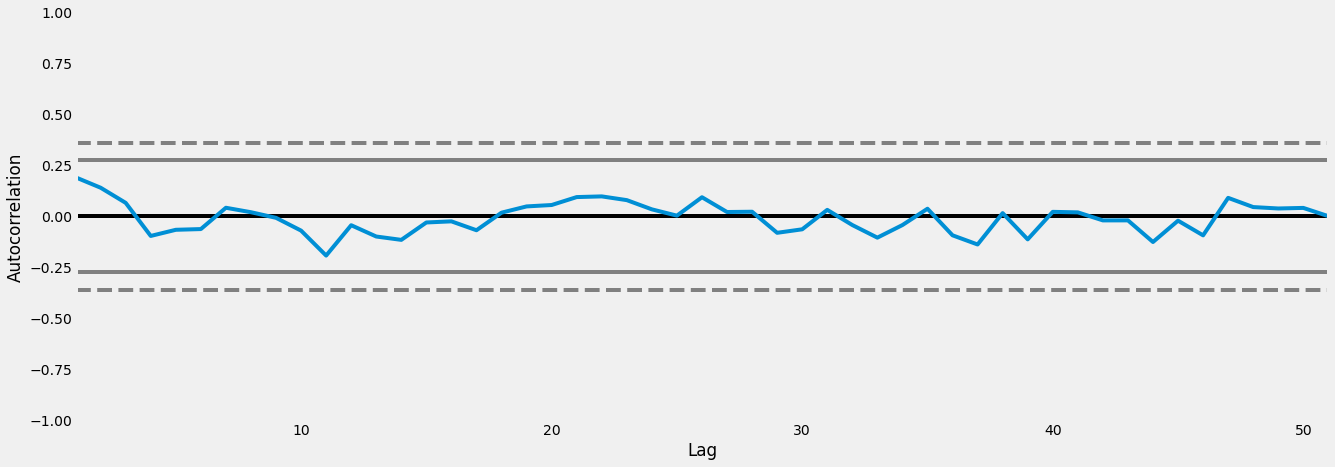

In [117]:
pd.plotting.autocorrelation_plot(bars_df.jma_return)

In [118]:
# bars_df[['jma_close','jma_high','jma_low']].plot()
bars_df[['jma_wq10', 'jma_wq90','jma_wmean']].plot_bokeh(sizing_mode="scale_height")
# plot_bokeh(sizing_mode="scale_height")

Figure(id='1001', ...)

In [ ]:
ticks2_df[ticks2_df.status=='clean'].set_index('date_time').loc[:, ['price', 'jma']].plot()

<AxesSubplot:>

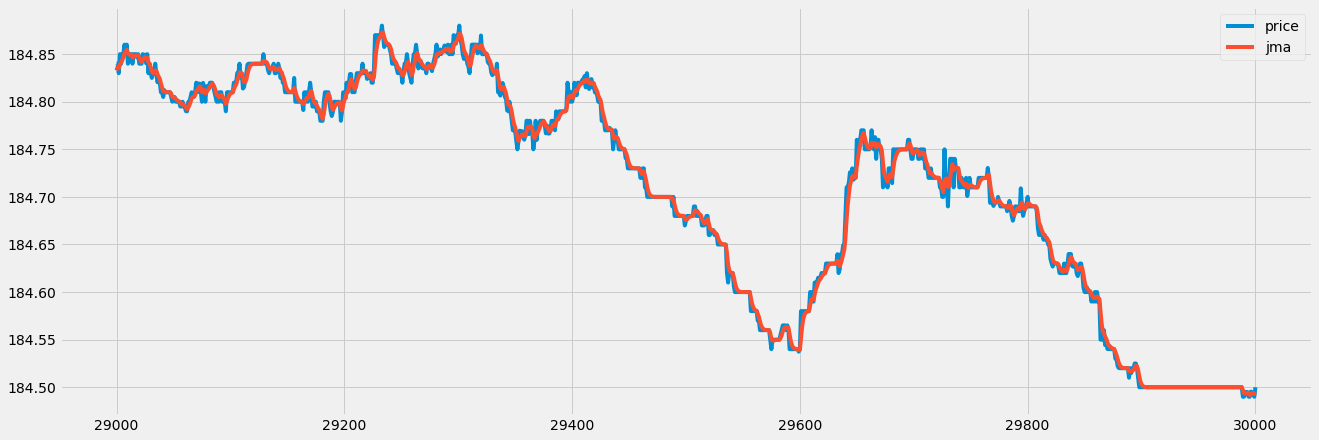

In [151]:
ixs += 1000
# ixs = 0
ixe = ixs+1000

ticks2_df[ticks2_df.status=='clean'].loc[ixs:ixe, ['price', 'jma']].plot()

# ticks2_df[['price', 'jma']][ixs:ixe].plot()

<AxesSubplot:xlabel='date_time'>

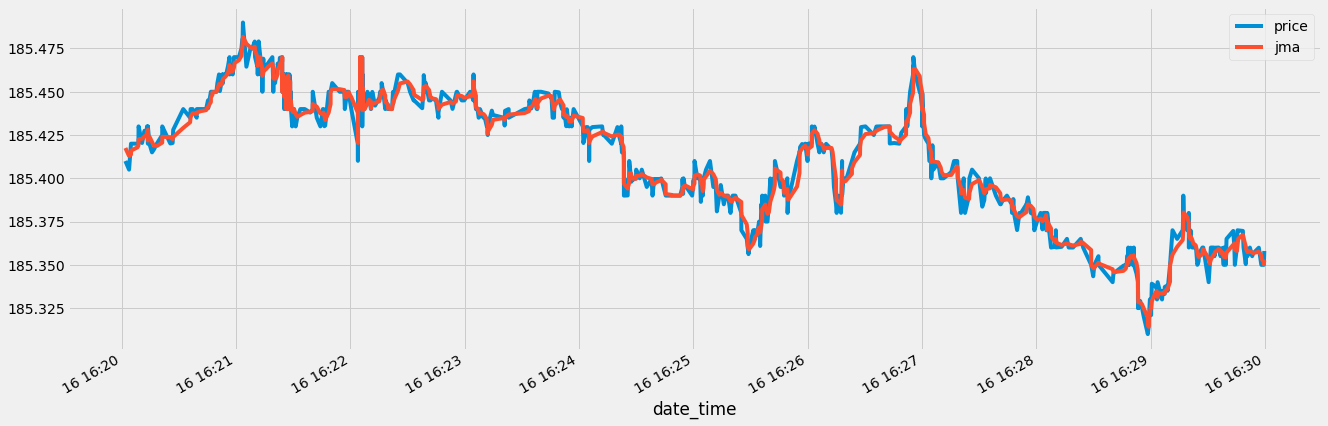

In [129]:
st = '16:20:00'
et = '16:30:00'

dfa = ticks2_df.set_index('date_time').between_time(st, et)[['price', 'jma']]
dfc = ticks2_df[ticks2_df.status=='clean'].set_index('date_time').between_time(st, et)[['price', 'jma']]

dfc[['price', 'jma']].plot()

# post-hoc JMA
# ft.jma_filter_df(dfc, col='price', length=7, power=2)[['price', 'jma']].plot()
# .plot_bokeh(sizing_mode="scale_height")

# Build Bars Workflow

In [ ]:
ray.init(ignore_reinit_error=True, num_cpus=4, dashboard_port=8080)

In [ ]:
daily_bar_stats_df, labeled_bar_dates, stacked_bars_df = bm.bars_workflow_ray(
    symbol, 
    start_date,
    end_date, 
    thresh,
)

In [ ]:
ray.shutdown()